# Speed optimization

Largest optimization introduced is pre-computing groupwise means

In [1]:
import numpy as np
import scipy.stats as stats
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import sklearn.linear_model as sk_lm
import statsmodels.api as sm
import imp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

In [3]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation')
import simulate as sim

In [4]:
# def mean_objective_perm(params, perm_means, perm_counts):

#     x_mat = df_mean[['treatment', 'intercept']].values
#     y_val, y_counts = perm_means, perm_counts
#     beta_hat = perm_start.reshape(-1, num_perm, order='F')
    
#     momcond = np.einsum('nm,nk->nmk', x_mat, y_val) - np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )
#     weighted_momcond = (momcond * y_counts).mean(axis=0)
        
#     return (weighted_momcond**2).sum()

In [5]:
def var_objective_perm(params):
    
    y_val, y_counts = df['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')
    mean_beta = self.mean_beta.reshape(-1, 1)

    var_beta = params.reshape(-1, 1)

    a = (x_mat*y**2)/self.q_sq
    b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
    c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
    d = np.exp(2*x_mat@mean_beta)*x_mat
    e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
    return a + b + c + d + e

### Set up some data

In [117]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
N = 10000
num_perm = 10000
X, z = sim.simulate_true_counts(
    N=N,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.0, 0.1]),
    num_levels=4,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)



hi


### Preprocessing step - must occur for each gene

In [118]:
%%time
df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df_val = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df_val['proportion'] = df_val['count'] / X.shape[0]

perm_proportions = stats.multinomial.rvs(
    N, 
    df_val['proportion'], 
    size=num_perm).T

df_mean = df.groupby(['treatment', 'intercept']).agg({'treatment':'size', 'y':'mean'}).rename(columns={'treatment':'group_count', 'y':'group_mean'}).reset_index()
df_mean['group_id'] = np.arange(df_mean.shape[0])
df_val = df_val.merge(df_mean, on=['treatment', 'intercept'], how='left')
df_mean['group_proportion'] = df_mean['group_count']/N

perm_vals = df_val['y'].values.reshape(-1, 1) * perm_proportions / df_val['group_count'].values.reshape(-1, 1)

perm_means = np.zeros((df_mean.shape[0], num_perm))
perm_counts = np.zeros((df_mean.shape[0], num_perm))
for group_id in range(df_mean.shape[0]):
    perm_means[group_id, :] = perm_vals[df_val['group_id']==group_id, :].sum(axis=0)
    perm_counts[group_id, :] = perm_proportions[df_val['group_id']==group_id, :].sum(axis=0)

CPU times: user 71.1 ms, sys: 0 ns, total: 71.1 ms
Wall time: 70.3 ms


In [119]:
def mean_objective_perm(params, perm_means, perm_proportions, df_mean, sep=False):

    x_mat = df_mean[['treatment', 'intercept']].values
    y_val, y_counts = perm_means, perm_proportions/N
    beta_hat = params.reshape(-1, num_perm, order='F')
    
    momcond = np.einsum('nm,nk->nmk', x_mat, y_val)/p
    
    momcond -= np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )
    
    weighted_momcond = np.einsum('ijk,ik->ijk', momcond, y_counts).mean(axis=0)
        
    #return tp1, tp2, tp3, tp4, tp5
    return (weighted_momcond**2).sum(axis=0) if sep else (weighted_momcond**2).sum()


def mean_objective_perm_old(params, sep=False):

    y_val, y_counts = df_val['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df_val[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')

    part_1 = ((x_mat*y_val)/p)

    part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

    part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

    part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)

    momcond = (part_1 - part_2*part_3)
    weighted_momcond = (momcond * y_counts).mean(axis=0)
        
    return (weighted_momcond**2).sum(axis=0) if sep else (weighted_momcond**2).sum()


def mean_objective(params, y_val, y_counts, x_mat):

#     y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
#     x_mat = df[['treatment', 'intercept']].values
    
    beta_hat = params.reshape(-1, 1)

    a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()




### Starting values for large optimization

In [120]:
perm_start = np.concatenate([np.array([1.0042849880247497, 0.11339659771439722]) for i in range(num_perm)])

### Debugging objective functions

In [121]:
%%time
mean_objective_perm_old(perm_start)#[:, :, 0]

CPU times: user 41.6 ms, sys: 509 µs, total: 42.1 ms
Wall time: 11.9 ms


1.1929421358570647

In [122]:
%%time
times = mean_objective_perm(perm_start, perm_means, perm_counts,df_mean)

CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 2.99 ms


In [123]:
%%time
res_old = sp.optimize.minimize(
        lambda x: mean_objective_perm_old(x, sep=False),
        perm_start,
        method='l-bfgs-b',
        jac=lambda x: gradient(x, lambda y: mean_objective_perm_old(y, sep=True), num_features=2),
        options={'disp': True})
res_old.x

CPU times: user 3.24 s, sys: 32.3 ms, total: 3.28 s
Wall time: 827 ms


array([0.97502337, 0.15944689, 1.01338053, ..., 0.09476379, 1.00029512,
       0.09522667])

In [124]:
%%time
res = sp.optimize.minimize(
        lambda x: mean_objective_perm(x, perm_means, perm_counts, df_mean),
        perm_start,
        method='l-bfgs-b',
        options={'gtol':1e-4,'ftol':1e-5},
        jac=lambda x: gradient(x, lambda y:  mean_objective_perm(y, perm_means, perm_counts, df_mean, sep=True), num_features=2))
res.x

CPU times: user 670 ms, sys: 15.5 ms, total: 686 ms
Wall time: 171 ms


array([0.99622867, 0.12294326, 1.02882352, ..., 0.09082361, 1.01413486,
       0.07189467])

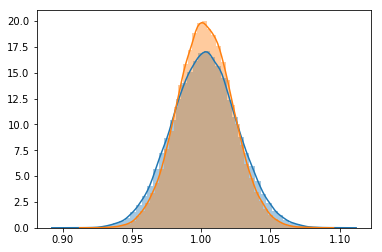

In [86]:
sns.distplot(res.x[::2])
sns.distplot(res_old.x[::2])

In [111]:
%%time
gradient(perm_start, lambda y: mean_objective_perm(y, perm_means, perm_counts, df_mean, sep=True))

CPU times: user 2.31 ms, sys: 111 µs, total: 2.42 ms
Wall time: 2.32 ms


array([12.01661249,  4.46427635,  2.36929645,  0.88203297,  2.73516011,
        1.02273279, -2.78291517, -1.02554522, -7.79738242, -2.87827038])

In [112]:
%%time
gradient(perm_start, lambda y: mean_objective_perm_old(y, sep=True))

CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.43 ms


array([ 0.07111637,  0.02644685,  0.02583715,  0.00960277,  0.01038137,
        0.00393316, -0.01510601, -0.00556113, -0.04754406, -0.01753686])

In [118]:
perm_start[0]/2

0.5021424940123749

In [121]:
np.split(perm_start, perm_start.shape[0]/2)

[array([1.00428499, 0.1133966 ]),
 array([1.00428499, 0.1133966 ]),
 array([1.00428499, 0.1133966 ]),
 array([1.00428499, 0.1133966 ]),
 array([1.00428499, 0.1133966 ])]

In [122]:
sp.linalg.block_diag(*np.split(perm_start, perm_start.shape[0]/2))

array([[1.00428499, 0.1133966 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.00428499, 0.1133966 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.00428499,
        0.1133966 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.00428499, 0.1133966 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.00428499, 0.1133966 ]])

In [13]:
EPS = np.MachAr().eps

def _get_epsilon(x, s, epsilon, n):
    if epsilon is None:
        h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
    else:
        if np.isscalar(epsilon):
            h = np.empty(n)
            h.fill(epsilon)
        else:  # pragma : no cover
            h = np.asarray(epsilon)
            if h.shape != x.shape:
                raise ValueError("If h is not a scalar it must have the same"
                                 " shape as x.")
    return h

def approx_fprime(x, f, epsilon=None, args=(), kwargs={}, centered=False):

    n = len(x)
    # TODO:  add scaled stepsize
    f0 = f(*((x,)+args), **kwargs)
    print(f0)
    dim = np.atleast_1d(f0).shape  # it could be a scalar
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    #print(grad.shape)
    ei = np.zeros((n,), float)
    
    if not centered:
        epsilon = _get_epsilon(x, 2, epsilon, n) 
        for k in range(n):
            ei[k] = epsilon[k]
            print(epsilon)
            print(f(*((x+ei,) + args), **kwargs))
            grad[k, :] = (f(*((x+ei,) + args), **kwargs) - f0)/epsilon[k]
            ei[k] = 0.0
    else:
        epsilon = _get_epsilon(x, 3, epsilon, n) / 2.
        for k in range(len(x)):
            ei[k] = epsilon[k]
            grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
                          f(*((x-ei,)+args), **kwargs))/(2 * epsilon[k])
            ei[k] = 0.0
    return grad.squeeze().T


def gradient(x, f_sep, num_features=2, epsilon=None, mat=False, args=(), kwargs={}):
    
    n = len(x)
    f0 = f_sep(*((x,)+args), **kwargs)
    dim = (1,)
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    
    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        res = ((f_sep(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features]).reshape(-1, 1)
        grad[start::num_features, :] = res
        ei[start::num_features] = 0.0
        
    grad = grad.squeeze().T
    return sp.linalg.block_diag(*np.split(grad, grad.shape[0]/num_features)) if mat else grad
        
def mean_hessian_p(x, p, num_features=2, epsilon=None, args=(), kwargs={'num_features':2}):
    
    n = len(x)
    f = mean_gradient
    f0 = f(*((x,)+args), **kwargs)
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    hess = [] # list of length num_features

    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        hess.append((f(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features][0])
        ei[start::num_features] = 0.0
    
    hess = np.vstack(hess)
    
    Hp_components = [hess[:, i:(i+num_features)]@p[i:(i+num_features)] for i in range(int(x.shape[0]/num_features))]
    
    return np.concatenate(Hp_components)
    

In [150]:
perm_start

array([1. , 0.1, 1. , 0.1, 1. , 0.1, 1. , 0.1, 1. , 0.1])

In [149]:
perm_start[0::2]

array([1., 1., 1., 1., 1.])